   # Taxi-Out Prediction

## Purpose of this project

To test several models to predict Taxi_out time for JFK Airport.

Taxi_out is the time aircrafts spend on the surface. The period of time when the aircraft leave the tereminal and actually takes off.

Reducing the taxi_out time will help in cutting the consumption of fuel.

### Description of the columns

There are $28820$ observations of $23$ variables.
Each observation is an individual flight.
- `MONTH`, `DAY_OF_MONTH`, `DAY_OF_WEEK` contain information about the date of the flight
- `OP_UNIQUE_CARRIER` contains ID of the airline (i.e. `AA` stands for American Airlines)
- `TAIL_NUM` is the tail number of the plane
- `DEST` is the destination airport code
- `DEP_DELAY` is the departure delay of the flight
- `CRS_ELAPSED_TIME` is expected duration of the light
- `DISTANCE` is the distance between airports
- `CRS_DEP_M` is scheduled departure time (in minutes after midnight)
- `DEP_TIME_M` is actual departure time (gate checkout)
- `CRS_ARR_M` is scheduled arrival time
- `Temperature`, `Dew Point`, `Humidity`, `Wind Speed`, `Wind Gust` and `Pressure` are the numeric characteristis of the weather
- `Wind` is the direction of the wind (`CALM` if calm, `VAR` if wind blows from various directions)
- `Condition` contains natural language description of the weather
- `sch_dep` is the number of flights scheduled for departure
- `sch_arr` is the number of flights scheduled for arrival 
- `TAXI_OUT` is the time between the actual pushback and wheels-off.

There are five caterogical variables: `OP_UNIQUE_CARRIER`, `TAIL_NUM`, `DEST`, `WIND` and `Condition`. 
The rest of the variables is numerical.


Our target variable is `TAXI_OUT`.


#### Reading the Data

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore 
from scipy.stats import shapiro
from sklearn.metrics import classification_report

In [39]:
df = pd.read_csv('M1_final.csv')

In [40]:
df.head(3)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,DEST,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,...,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Condition,sch_dep,sch_arr,TAXI_OUT
0,11,1,5,B6,N828JB,CHS,-1,124,636,324,...,34,58,W,25,38,29.86,Fair / Windy,9,17,14
1,11,1,5,B6,N992JB,LAX,-7,371,2475,340,...,34,58,W,25,38,29.86,Fair / Windy,9,17,15
2,11,1,5,B6,N959JB,FLL,40,181,1069,301,...,34,58,W,25,38,29.86,Fair / Windy,9,17,22


## DATA PROCESSING

#### Renaming the columns for better understanding:-

In [41]:
column_names={"OP_UNIQUE_CARRIER":"CARRIER_CODE",
                "CRS_ELAPSED_TIME":"SCHEDULED_DURATION",
                "CRS_DEP_M":"SCHEDULED_DEPARTURE",
                "DEP_TIME_M":"ACTUAL_DEPATURE",
                "CRS_ARR_M":"SCHEDULED_ARRIVAL",
                "sch_dep":"FLT_SCH_DEPATURE",
                "sch_arr":"FLT_SCH_ARRIVAL"
               }

df = df.rename(column_names, axis=1)

#### Dropping unnecessary features:-

Dropping TAIL_NUM as it act as a unique identifier and dosen't help the model for prediction

In [42]:
df=df.drop('TAIL_NUM',axis=1) 

Dropping MONTH as it holds only 11, 12,  1 and it is not going to help the model for prediction

In [43]:
df['MONTH'].unique()

array([11, 12,  1], dtype=int64)

In [44]:
df=df.drop('MONTH',axis=1)

Dropping the DAY_OF_MONTH for the same as above reason:-

In [45]:
df.DAY_OF_MONTH.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int64)

In [46]:
df=df.drop('DAY_OF_MONTH',axis=1)


#### Dew point feature | Cleaning 

In [47]:
df['Dew Point'].unique()

array(['34', '32', '33', '31', '30', '29', '67', '35', '36', '38', '39',
       '40', '41', '42', '28', '27', '46', '37', '44', '45', '52', '53',
       '54', '56', '57', '59', '58', '50', '43', '48', '49', '47', '21',
       '20', '22', '24', '23', '19', '18', '16', '13', '12', '14', '15',
       '17', '26', '25', '51', '55', '6\xa0', '9\xa0', '5\xa0', '8\xa0',
       '10', '4\xa0', '7\xa0', '3\xa0', '2\xa0', '11', '0\xa0', '-1',
       '1\xa0', '-2', '-3'], dtype=object)

In [48]:
df['Dew Point'].replace(u'\xa0',u'0', regex=True, inplace=True)

In [49]:
df['Dew Point'].unique()

array(['34', '32', '33', '31', '30', '29', '67', '35', '36', '38', '39',
       '40', '41', '42', '28', '27', '46', '37', '44', '45', '52', '53',
       '54', '56', '57', '59', '58', '50', '43', '48', '49', '47', '21',
       '20', '22', '24', '23', '19', '18', '16', '13', '12', '14', '15',
       '17', '26', '25', '51', '55', '60', '90', '80', '10', '70', '11',
       '00', '-1', '-2', '-3'], dtype=object)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28820 entries, 0 to 28819
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DAY_OF_WEEK          28820 non-null  int64  
 1   CARRIER_CODE         28820 non-null  object 
 2   DEST                 28820 non-null  object 
 3   DEP_DELAY            28820 non-null  int64  
 4   SCHEDULED_DURATION   28820 non-null  int64  
 5   DISTANCE             28820 non-null  int64  
 6   SCHEDULED_DEPARTURE  28820 non-null  int64  
 7   ACTUAL_DEPATURE      28820 non-null  int64  
 8   SCHEDULED_ARRIVAL    28820 non-null  int64  
 9   Temperature          28820 non-null  int64  
 10  Dew Point            28820 non-null  object 
 11  Humidity             28820 non-null  int64  
 12  Wind                 28818 non-null  object 
 13  Wind Speed           28820 non-null  int64  
 14  Wind Gust            28820 non-null  int64  
 15  Pressure             28820 non-null 

In [55]:
df['Dew Point'] = df['Dew Point'].astype('int')

####  Wind feature | clubbing into 6 main categories

In [56]:
df['Wind'].value_counts()

W       3273
NW      3173
NNW     2570
WSW     2567
N       2453
SW      2354
WNW     2145
S       1879
SSW     1632
NNE     1280
ENE     1124
E       1068
NE      1044
CALM     835
ESE      466
SE       345
SSE      315
VAR      295
Name: Wind, dtype: int64

In [57]:
df['Wind'] = df['Wind'].str[0]

In [58]:
df['Wind'].unique()

array(['W', 'N', 'S', 'E', 'C', 'V', nan], dtype=object)

In [59]:
df['Wind'].value_counts()

N    10520
W     7985
S     6525
E     2658
C      835
V      295
Name: Wind, dtype: int64

#### DAY_OF_WEEK feature | numerical to categorical

In [60]:
df['DAY_OF_WEEK']=df['DAY_OF_WEEK'].astype('object')

In [61]:
df.DAY_OF_WEEK.unique()

array([5, 6, 7, 1, 2, 3, 4], dtype=object)

In [62]:
df.DAY_OF_WEEK.value_counts()

5    4708
7    4150
4    4135
2    4065
1    4051
3    4013
6    3698
Name: DAY_OF_WEEK, dtype: int64

#### SCHEDULED_DEPARTURE feature | Bin Creation

In [63]:
df['SCHEDULED_DEPARTURE'] = pd.cut(df['SCHEDULED_DEPARTURE'],
                                   bins=[0,180,720,1020,1200,1440],
                                   labels=['Midnight','Morning','Noon','Evening','Night'])

In [64]:
df['SCHEDULED_DEPARTURE']=df['SCHEDULED_DEPARTURE'].astype('object')

In [65]:
df.SCHEDULED_DEPARTURE.value_counts()

Morning    11917
Noon        8287
Evening     4991
Night       3625
Name: SCHEDULED_DEPARTURE, dtype: int64

#### ACTUAL_DEPATURE feature | Bin Creation

In [66]:
df['ACTUAL_DEPATURE'] = pd.cut(df['ACTUAL_DEPATURE'],
                               bins=[0,180,720,1020,1200,1440],
                               labels=['Midnight','Morning','Noon','Evening','Night'])

In [67]:
df['ACTUAL_DEPATURE']=df['ACTUAL_DEPATURE'].astype('object')

In [68]:
df.ACTUAL_DEPATURE.value_counts()

Morning     11831
Noon         8061
Evening      4965
Night        3821
Midnight      142
Name: ACTUAL_DEPATURE, dtype: int64

#### SCHEDULED_ARRIVAL feature | Bin Creation

In [69]:
df['SCHEDULED_ARRIVAL'] = pd.cut(df['SCHEDULED_ARRIVAL'],
                                 bins=[0,180,720,1020,1200,1440],
                                 labels=['Midnight','Morning','Noon','Evening','Night'])

In [70]:
df['SCHEDULED_ARRIVAL']=df['SCHEDULED_ARRIVAL'].astype('object')

In [71]:
df.SCHEDULED_ARRIVAL.value_counts()

Morning     7713
Noon        7317
Night       7090
Evening     5169
Midnight    1531
Name: SCHEDULED_ARRIVAL, dtype: int64

#### SPEED feature | New feature creation (Diatance/ time = speed)

In [72]:
df['DISTANCE']=df['DISTANCE']*1.60934  #COnverting miles into Kilo metres

In [73]:
df['SCHEDULED_DURATION']=df['SCHEDULED_DURATION'] / 60     #Coverting Scheduled duration into hour

In [74]:
df['speed']=df['DISTANCE'] / df['SCHEDULED_DURATION']  #Calc.Speed in Km per Hour

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='speed'>

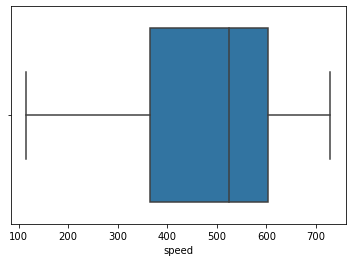

In [75]:
sns.boxplot(df['speed'])

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-0.5665480389721033


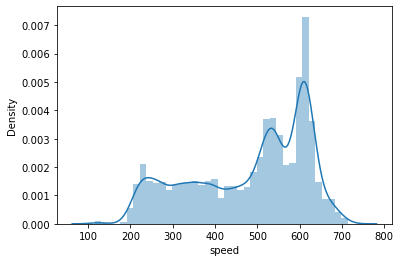

In [76]:
sns.distplot(df['speed'])
print(df['speed'].skew())

#### Region feature | New feature creation 

- Created with the help of DEST feature
- Combined the destination into groups based on political Map

In [77]:
df['DEST'].unique()

array(['CHS', 'LAX', 'FLL', 'MCO', 'ATL', 'ORD', 'BUF', 'LGB', 'LAS',
       'DCA', 'PHX', 'SFO', 'SJU', 'SLC', 'BOS', 'SAV', 'SYR', 'MSP',
       'SEA', 'MIA', 'PDX', 'TPA', 'BTV', 'IAH', 'DEN', 'RSW', 'ORF',
       'JAX', 'MSY', 'CLT', 'BNA', 'RDU', 'SAN', 'SJC', 'ROC', 'DFW',
       'IAD', 'AUS', 'DTW', 'PWM', 'SRQ', 'CMH', 'HNL', 'PBI', 'BWI',
       'CLE', 'BUR', 'PIT', 'RIC', 'IND', 'CVG', 'SMF', 'ONT', 'SAT',
       'PSP', 'OAK', 'ABQ', 'PSE', 'ORH', 'BQN', 'STT', 'RNO', 'PHL',
       'EGE', 'JAC'], dtype=object)

In [78]:
df['Region']=np.nan

In [79]:
df.loc[df['DEST']=='BOS', 'Region'] ='North East'
df.loc[df['DEST']=='BTV', 'Region'] ='North East'
df.loc[df['DEST']=='BUF', 'Region'] ='North East'
df.loc[df['DEST']=='ORH', 'Region'] ='North East'
df.loc[df['DEST']=='PHL', 'Region'] ='North East'
df.loc[df['DEST']=='PIT', 'Region'] ='North East'
df.loc[df['DEST']=='ROC', 'Region'] ='North East'
df.loc[df['DEST']=='SYR', 'Region'] ='North East'
df.loc[df['DEST']=='ATL', 'Region'] ='South'
df.loc[df['DEST']=='AUS', 'Region'] ='South'
df.loc[df['DEST']=='BNA', 'Region'] ='South'
df.loc[df['DEST']=='BQN', 'Region'] ='South'
df.loc[df['DEST']=='CHS', 'Region'] ='South'
df.loc[df['DEST']=='CLT', 'Region'] ='South'
df.loc[df['DEST']=='DTW', 'Region'] ='South'
df.loc[df['DEST']=='FLL', 'Region'] ='South'
df.loc[df['DEST']=='HNL', 'Region'] ='South'
df.loc[df['DEST']=='IAH', 'Region'] ='South'
df.loc[df['DEST']=='JAC', 'Region'] ='South'
df.loc[df['DEST']=='JAX', 'Region'] ='South'
df.loc[df['DEST']=='MCO', 'Region'] ='South'
df.loc[df['DEST']=='MIA', 'Region'] ='South'
df.loc[df['DEST']=='MSY', 'Region'] ='South'
df.loc[df['DEST']=='PBI', 'Region'] ='South'
df.loc[df['DEST']=='PSE', 'Region'] ='South'
df.loc[df['DEST']=='RIC', 'Region'] ='South'
df.loc[df['DEST']=='RSW', 'Region'] ='South'
df.loc[df['DEST']=='SAT', 'Region'] ='South'
df.loc[df['DEST']=='SAV', 'Region'] ='South'
df.loc[df['DEST']=='SRQ', 'Region'] ='South'
df.loc[df['DEST']=='STT', 'Region'] ='South'
df.loc[df['DEST']=='TPA', 'Region'] ='South'

df.loc[df['DEST']=='CLE', 'Region'] ='Mid West'
df.loc[df['DEST']=='CMH', 'Region'] ='Mid West'
df.loc[df['DEST']=='CVG', 'Region'] ='Mid West'
df.loc[df['DEST']=='DFW', 'Region'] ='Mid West'
df.loc[df['DEST']=='IND', 'Region'] ='Mid West'
df.loc[df['DEST']=='MSP', 'Region'] ='Mid West'
df.loc[df['DEST']=='ORD', 'Region'] ='Mid West'
df.loc[df['DEST']=='ORF', 'Region'] ='Mid West'

df.loc[df['DEST']=='ABQ', 'Region'] ='West'
df.loc[df['DEST']=='BUR', 'Region'] ='West'
df.loc[df['DEST']=='BWI', 'Region'] ='West'
df.loc[df['DEST']=='DCA', 'Region'] ='West'
df.loc[df['DEST']=='DEN', 'Region'] ='West'
df.loc[df['DEST']=='EGE', 'Region'] ='West'
df.loc[df['DEST']=='IAD', 'Region'] ='West'
df.loc[df['DEST']=='LAS', 'Region'] ='West'
df.loc[df['DEST']=='LAX', 'Region'] ='West'
df.loc[df['DEST']=='LGB', 'Region'] ='West'
df.loc[df['DEST']=='ONT', 'Region'] ='West'
df.loc[df['DEST']=='OAK', 'Region'] ='West'
df.loc[df['DEST']=='PDX', 'Region'] ='West'
df.loc[df['DEST']=='PHX', 'Region'] ='West'
df.loc[df['DEST']=='PSP', 'Region'] ='West'
df.loc[df['DEST']=='PWM', 'Region'] ='West'
df.loc[df['DEST']=='RDU', 'Region'] ='West'
df.loc[df['DEST']=='RNO', 'Region'] ='West'
df.loc[df['DEST']=='SAN', 'Region'] ='West'
df.loc[df['DEST']=='SEA', 'Region'] ='West'
df.loc[df['DEST']=='SFO', 'Region'] ='West'
df.loc[df['DEST']=='SJC', 'Region'] ='West'
df.loc[df['DEST']=='SJU', 'Region'] ='West'
df.loc[df['DEST']=='SLC', 'Region'] ='West'
df.loc[df['DEST']=='SMF', 'Region'] ='West'


In [80]:
df['Region'].value_counts()

West          12128
South          9899
North East     3979
Mid West       2814
Name: Region, dtype: int64

In [81]:
# Dropping DEST As region is created
df = df.drop('DEST', axis = 1)

#### DEP_DELAY_Cat | New Feature Creation

- created by seperating DEP DELAY into 3 bins (Early, Ontime, Delayed)

In [82]:
df['DEP_DELAY'].max()

1276

In [83]:
df['DEP_DELAY'] = pd.cut(df['DEP_DELAY'],
                           bins=[-22,-1,0,1276],
                           labels=['EARLY','ONTIME','DELAYED'])

In [84]:
df['DEP_DELAY'].value_counts(normalize=True)

EARLY      0.678303
DELAYED    0.270828
ONTIME     0.050869
Name: DEP_DELAY, dtype: float64

In [85]:
df['DEP_DELAY']=df['DEP_DELAY'].astype('object')

In [86]:
df.groupby('DEP_DELAY')['TAXI_OUT'].mean()

DEP_DELAY
DELAYED    21.622422
EARLY      20.474473
ONTIME     21.905866
Name: TAXI_OUT, dtype: float64

#### Wind Gust Feature | Bin Creation

In [87]:
df['Wind Gust'] = pd.cut(df['Wind Gust'],
                           bins=[-1,1,14,25,50],
                           labels=['No Gust','Avg Gust','strong Gust','violent Gust'])
df['Wind Gust'] = df['Wind Gust'].astype('object')

In [88]:
df['Wind Gust'].unique()

array(['violent Gust', 'strong Gust', 'No Gust'], dtype=object)

<AxesSubplot:xlabel='Wind Gust'>

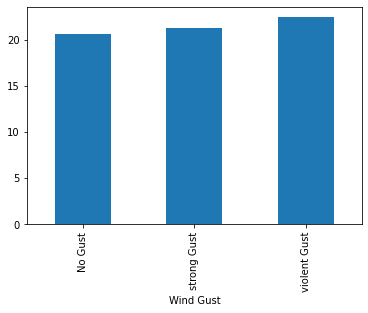

In [89]:
df.groupby('Wind Gust')['TAXI_OUT'].mean().plot(kind='bar')

#### Null Value Treatment

In [90]:
a=df.isnull().sum()
a[a>0]

DEP_DELAY    1
Wind         2
dtype: int64

In [91]:
df = df.dropna(axis =0, how ='any')

In [92]:
df.isnull().sum()

DAY_OF_WEEK            0
CARRIER_CODE           0
DEP_DELAY              0
SCHEDULED_DURATION     0
DISTANCE               0
SCHEDULED_DEPARTURE    0
ACTUAL_DEPATURE        0
SCHEDULED_ARRIVAL      0
Temperature            0
Dew Point              0
Humidity               0
Wind                   0
Wind Speed             0
Wind Gust              0
Pressure               0
Condition              0
FLT_SCH_DEPATURE       0
FLT_SCH_ARRIVAL        0
TAXI_OUT               0
speed                  0
Region                 0
dtype: int64

#### Numerical and Categorical Features 

In [93]:
df_num = df.select_dtypes(include=np.number)
print('numerical : ', df_num.columns)

numerical :  Index(['SCHEDULED_DURATION', 'DISTANCE', 'Temperature', 'Dew Point',
       'Humidity', 'Wind Speed', 'Pressure', 'FLT_SCH_DEPATURE',
       'FLT_SCH_ARRIVAL', 'TAXI_OUT', 'speed'],
      dtype='object')


In [94]:
df_cat = df.select_dtypes(include=np.object)
print('categorical : ', df_cat.columns)

categorical :  Index(['DAY_OF_WEEK', 'CARRIER_CODE', 'DEP_DELAY', 'SCHEDULED_DEPARTURE',
       'ACTUAL_DEPATURE', 'SCHEDULED_ARRIVAL', 'Wind', 'Wind Gust',
       'Condition', 'Region'],
      dtype='object')


<ipython-input-94-cc41a49e2437>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_cat = df.select_dtypes(include=np.object)


#### HEAT MAP | CORRELLATON

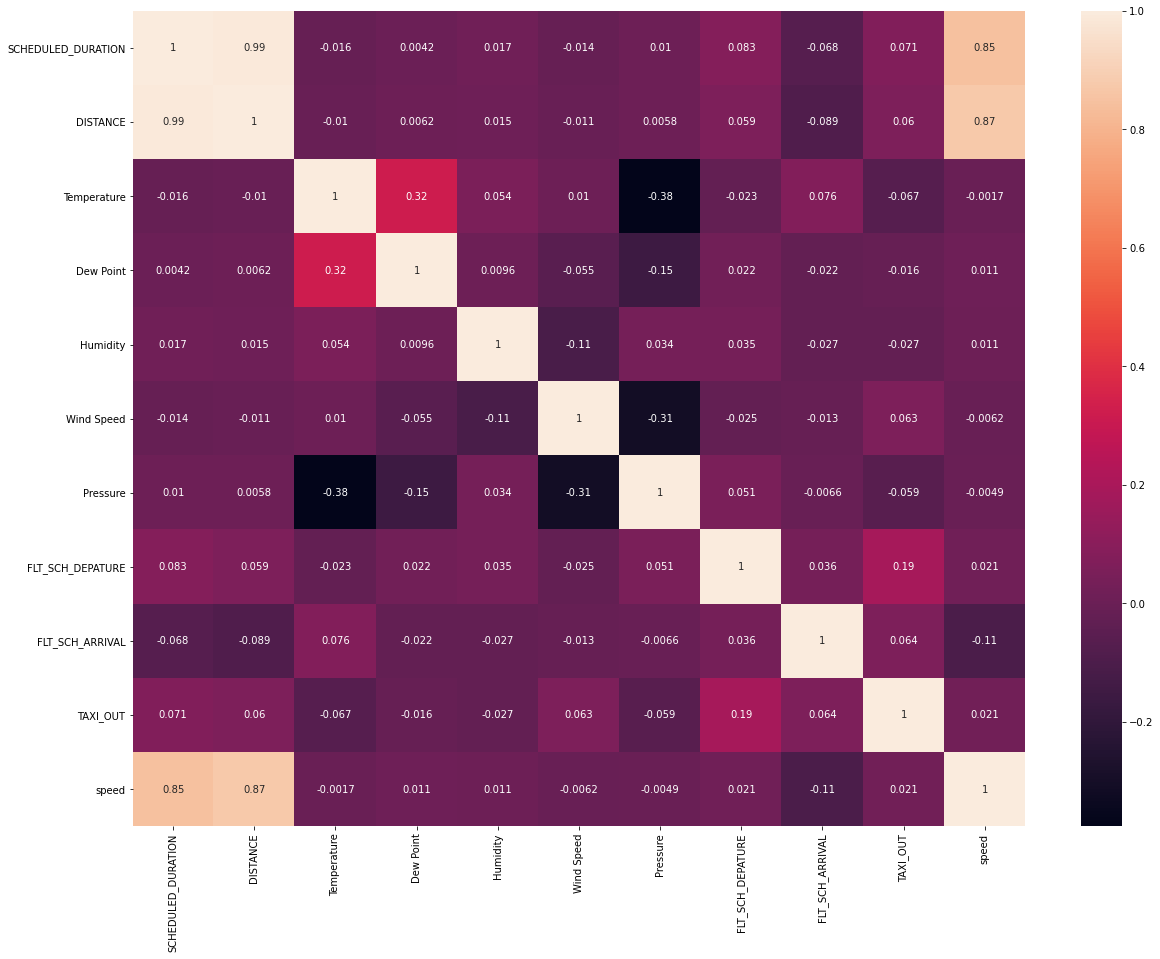

In [95]:
plt.figure(figsize = (20,15))
sns.heatmap(df.corr(), annot = True)
plt.show()

#### MULTICOLLINEARITY 

In [96]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [97]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif.sort_values('VIF',ascending = False)

    return(vif.sort_values('VIF',ascending = False))

In [98]:
X =df_num
calc_vif(X)

,Features,VIF
0,SCHEDULED_DURATION,574.039716
1,DISTANCE,455.300659
6,Pressure,127.081911
10,speed,71.419868
2,Temperature,30.511351
8,FLT_SCH_ARRIVAL,13.696191
7,FLT_SCH_DEPATURE,12.861447
9,TAXI_OUT,10.836809
3,Dew Point,7.546810
4,Humidity,7.189974


In [99]:
df = df.drop('SCHEDULED_DURATION',axis = 1)
df_num = df.select_dtypes(include=np.number)

In [100]:
calc_vif(df_num)

,Features,VIF
5,Pressure,88.073969
9,speed,56.909645
1,Temperature,30.448543
7,FLT_SCH_ARRIVAL,13.202695
0,DISTANCE,13.014194
6,FLT_SCH_DEPATURE,12.273315
8,TAXI_OUT,10.818533
2,Dew Point,7.546284
3,Humidity,7.186645
4,Wind Speed,4.955644


In [101]:
df = df.drop('Pressure',axis = 1)
df_num = df.select_dtypes(include=np.number)

In [102]:
calc_vif(df_num)

,Features,VIF
8,speed,41.014583
1,Temperature,25.029469
6,FLT_SCH_ARRIVAL,11.636480
5,FLT_SCH_DEPATURE,11.183355
0,DISTANCE,11.025714
7,TAXI_OUT,10.018083
2,Dew Point,7.481908
3,Humidity,6.707569
4,Wind Speed,4.763984


In [103]:
df = df.drop('Temperature',axis = 1)
df_num = df.select_dtypes(include=np.number)

In [104]:
calc_vif(df_num)

,Features,VIF
7,speed,36.550059
4,FLT_SCH_DEPATURE,10.997994
5,FLT_SCH_ARRIVAL,10.605649
0,DISTANCE,10.459038
6,TAXI_OUT,9.970597
2,Humidity,6.429507
1,Dew Point,6.197589
3,Wind Speed,4.638584


In [105]:
df = df.drop('speed',axis = 1)
df_num = df.select_dtypes(include=np.number)

In [106]:
calc_vif(df_num)

,Features,VIF
4,FLT_SCH_DEPATURE,10.624258
5,FLT_SCH_ARRIVAL,9.747826
6,TAXI_OUT,9.735338
2,Humidity,6.045079
1,Dew Point,5.842661
3,Wind Speed,4.411696
0,DISTANCE,2.950268


In [107]:
df = df.drop('FLT_SCH_DEPATURE',axis = 1)
df_num = df.select_dtypes(include=np.number)

In [108]:
calc_vif(df_num)

,Features,VIF
4,FLT_SCH_ARRIVAL,9.081380
5,TAXI_OUT,8.611231
2,Humidity,5.780214
1,Dew Point,5.651713
3,Wind Speed,4.361770
0,DISTANCE,2.896138


#### OUTLIER TREATMENT

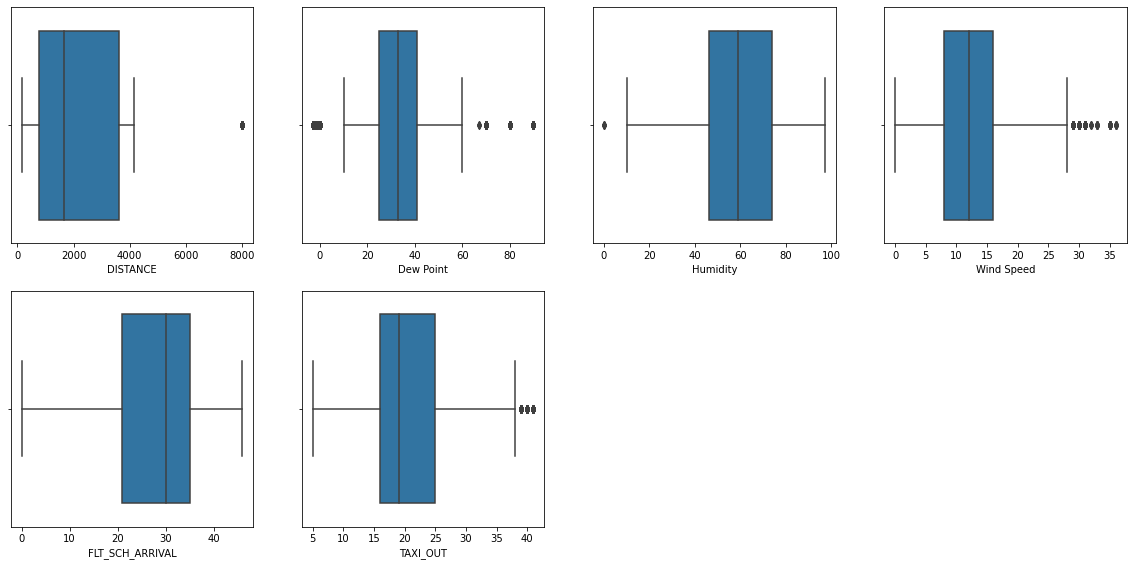

In [109]:
k = 1
plt.figure(figsize =(20,20))
for i in df_num.columns:
    if(df[i].dtypes != 'object'):
        plt.subplot(4,4,k)
        sns.boxplot(x=df[i])
        k+=1

In [110]:
from scipy import stats

In [111]:
def capping(df,columns,lower_end,upper_end):
    for i in columns:
        stats.mstats.winsorize(a=df[i],limits=(lower_end,upper_end),inplace=True)

In [112]:
capping(df,df_num.columns,0.02,0.02)

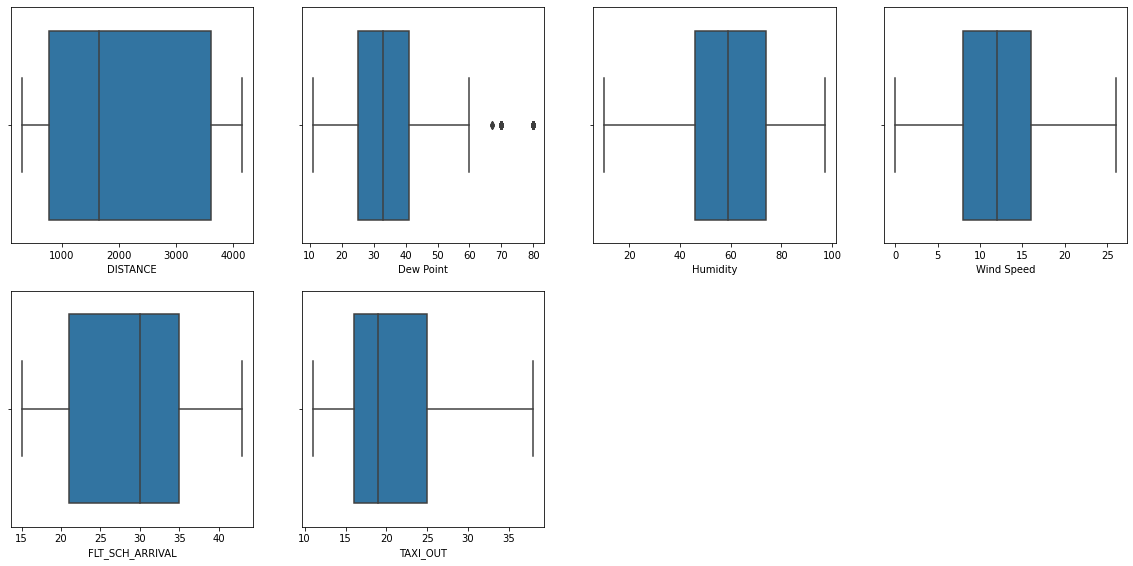

In [113]:
k = 1
plt.figure(figsize =(20,20))
for i in df_num.columns:
    if(df[i].dtypes != 'object'):
        plt.subplot(4,4,k)
        sns.boxplot(x=df[i])
        k+=1

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


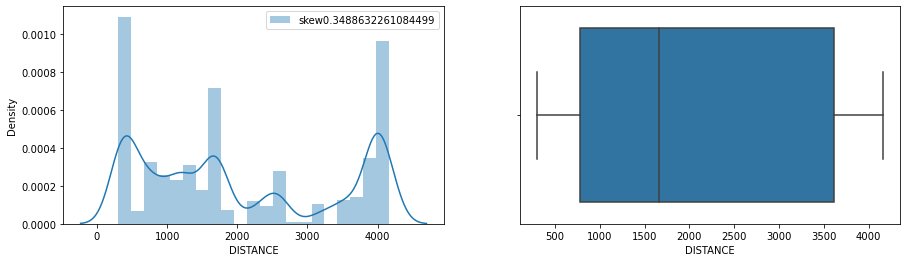

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


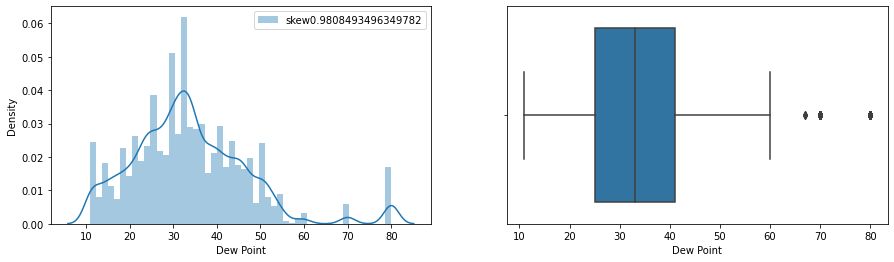

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


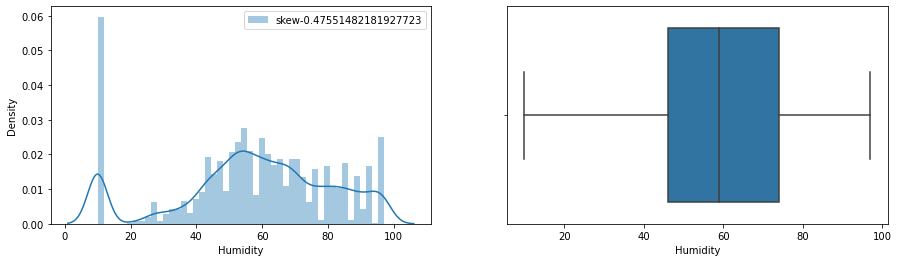

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


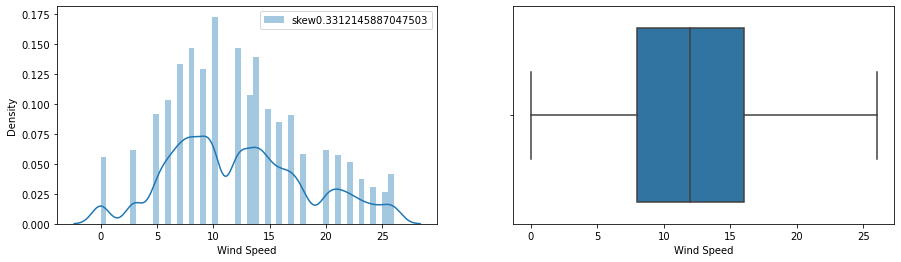

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


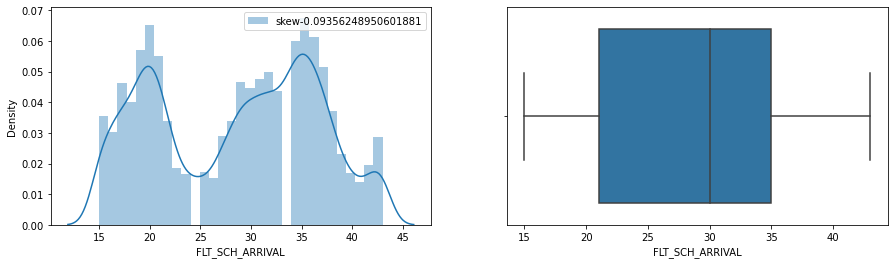

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


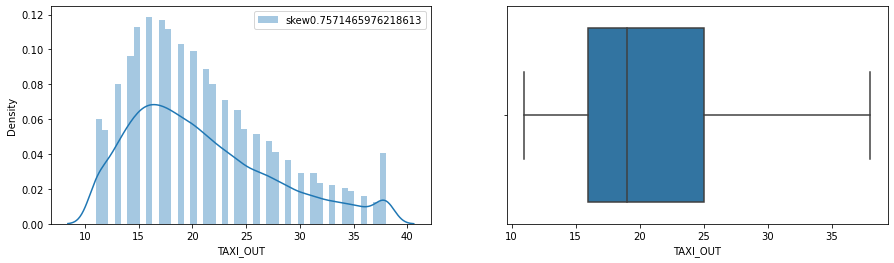

In [114]:
for i in df_num.columns:
    plt.figure(figsize=(15,4))
    plt.subplot(121)
    sns.distplot(df[i],label='skew'+str(df[i].skew()))
    plt.legend()
    plt.subplot(122)
    sns.boxplot(df[i])
    plt.show()

#### Categorising Target variable

In [115]:
df['TAXI_OUT'] = pd.cut(df['TAXI_OUT'], bins=[0,22,45],
                             include_lowest=True, labels = ['L','H'])
df['TAXI_OUT'].value_counts().sort_values()

H     9838
L    18979
Name: TAXI_OUT, dtype: int64

In [116]:
df['TAXI_OUT'] = df['TAXI_OUT'].astype('object')

#### Categorical and numerical columns:

In [117]:
num = df.select_dtypes(exclude = 'object')

In [118]:
cat = df.select_dtypes(include = 'object')

#### Label Encoding

In [119]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()

In [120]:
cat['TAXI_OUT'] =LE.fit_transform(cat['TAXI_OUT'])
y = cat['TAXI_OUT']
cat = cat.drop('TAXI_OUT',axis=1)

<ipython-input-120-d5307685c840>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['TAXI_OUT'] =LE.fit_transform(cat['TAXI_OUT'])


In [121]:
y.unique()

array([1, 0])

#### One Hot Encoding

In [122]:
cat_OHE=[]
for i in cat.columns:
    if cat[i].nunique() >5:
        cat[i]=LE.fit_transform(cat[i])
    else:
        cat_OHE.append(i)
print(cat_OHE)

['DEP_DELAY', 'SCHEDULED_DEPARTURE', 'ACTUAL_DEPATURE', 'SCHEDULED_ARRIVAL', 'Wind Gust', 'Region']


In [123]:
cat=pd.get_dummies(data=cat,columns=cat_OHE,drop_first=True)

#### SCALING

In [124]:
from sklearn.preprocessing import StandardScaler

In [125]:
ss = StandardScaler()
num[['Dew Point','Humidity','Wind Speed','FLT_SCH_ARRIVAL']]=ss.fit_transform(num[['Dew Point','Humidity','Wind Speed','FLT_SCH_ARRIVAL']])
num_scaled = num
num_scaled.head(3)

<ipython-input-125-05e9489ac2bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num[['Dew Point','Humidity','Wind Speed','FLT_SCH_ARRIVAL']]=ss.fit_transform(num[['Dew Point','Humidity','Wind Speed','FLT_SCH_ARRIVAL']])
C:\Users\HP\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,DISTANCE,Dew Point,Humidity,Wind Speed,FLT_SCH_ARRIVAL
0,1023.54024,0.019444,0.011312,2.087533,-1.435786
1,3983.11650,0.019444,0.011312,2.087533,-1.435786
2,1720.38446,0.019444,0.011312,2.087533,-1.435786


#### INDEPENDENT AND DEPENDENT VARIABLE

In [126]:
x=pd.concat([num_scaled,cat],axis=1)

In [127]:
x.head()

,DISTANCE,Dew Point,Humidity,Wind Speed,FLT_SCH_ARRIVAL,DAY_OF_WEEK,CARRIER_CODE,Wind,Condition,DEP_DELAY_EARLY,...,ACTUAL_DEPATURE_Noon,SCHEDULED_ARRIVAL_Midnight,SCHEDULED_ARRIVAL_Morning,SCHEDULED_ARRIVAL_Night,SCHEDULED_ARRIVAL_Noon,Wind Gust_strong Gust,Wind Gust_violent Gust,Region_North East,Region_South,Region_West
0,1023.54024,0.019444,0.011312,2.087533,-1.435786,4,3,5,4,1,...,0,0,1,0,0,0,1,0,1,0
1,3983.11650,0.019444,0.011312,2.087533,-1.435786,4,3,5,4,1,...,0,0,1,0,0,0,1,0,0,1
2,1720.38446,0.019444,0.011312,2.087533,-1.435786,4,3,5,4,0,...,0,0,1,0,0,0,1,0,1,0
3,1519.21696,0.019444,0.011312,2.087533,-1.435786,4,3,5,4,1,...,0,0,1,0,0,0,1,0,1,0
4,1223.09840,-0.130495,0.011312,1.923145,-1.435786,4,4,5,4,1,...,0,0,1,0,0,0,1,0,1,0


In [128]:
y.value_counts()

1    18979
0     9838
Name: TAXI_OUT, dtype: int64

#### NORMALITY CHECK

In [129]:
for i in x.columns:
    print(i,shapiro(x[i]))

DISTANCE ShapiroResult(statistic=0.8700273036956787, pvalue=0.0)
Dew Point ShapiroResult(statistic=0.9400031566619873, pvalue=0.0)
Humidity ShapiroResult(statistic=0.9476242065429688, pvalue=0.0)
Wind Speed ShapiroResult(statistic=0.9742045402526855, pvalue=0.0)
FLT_SCH_ARRIVAL ShapiroResult(statistic=0.9436162114143372, pvalue=0.0)
DAY_OF_WEEK ShapiroResult(statistic=0.9202601313591003, pvalue=0.0)
CARRIER_CODE ShapiroResult(statistic=0.8928426504135132, pvalue=0.0)
Wind ShapiroResult(statistic=0.8543198108673096, pvalue=0.0)
Condition ShapiroResult(statistic=0.8009821772575378, pvalue=0.0)
DEP_DELAY_EARLY ShapiroResult(statistic=0.5885157585144043, pvalue=0.0)
DEP_DELAY_ONTIME ShapiroResult(statistic=0.2264488935470581, pvalue=0.0)
SCHEDULED_DEPARTURE_Morning ShapiroResult(statistic=0.6258331537246704, pvalue=0.0)
SCHEDULED_DEPARTURE_Night ShapiroResult(statistic=0.3885807991027832, pvalue=0.0)
SCHEDULED_DEPARTURE_Noon ShapiroResult(statistic=0.5675264000892639, pvalue=0.0)
ACTUAL_DE

C:\Users\HP\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### TRAIN TEST SPLIT

In [130]:
from sklearn.model_selection import train_test_split,GridSearchCV
import statsmodels.api as sm

In [140]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=45)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((20171, 27), (8646, 27), (20171,), (8646,))

### LOGISTIC REGRESSION

In [141]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
xc_train = sm.add_constant(x_train)
xc_test = sm.add_constant(x_test)

logit_full_model = sm.Logit(y_train,xc_train).fit()
logit_full_model.summary()

Optimization terminated successfully.
         Current function value: 0.624874
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               TAXI_OUT   No. Observations:                20171
Model:                          Logit   Df Residuals:                    20143
Method:                           MLE   Df Model:                           27
Date:                Sat, 25 Sep 2021   Pseudo R-squ.:                 0.02665
Time:                        20:25:32   Log-Likelihood:                -12604.
converged:                       True   LL-Null:                       -12949.
Covariance Type:            nonrobust   LLR p-value:                4.518e-128
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.4899      0.104      4.697      0.000       0.285       0.694
DISTANCE                    -9.037e-06   1.72e-05     -0.526      0.599   -4.27e-05    2.46e-05
Dew Point                       0.0032      0.015      0.208      0.835      -0.027       0.033
Humidity                        0.0334      0.016      2.145      0.032       0.003       0.064
Wind Speed                     -0.0046      0.021     -0.213      0.832      -0.047       0.038
FLT_SCH_ARRIVAL                -0.2476      0.023    -10.698      0.000      -0.293      -0.202
DAY_OF_WEEK                    -0.0176      0.008     -2.273      0.023      -0.033      -0.002
CARRIER_CODE                   -0.0263      0.008     -3.178      0.001      -0.042      -0.010
Wind                            0.0582      0.011      5.280      0.000       0.037       0.080
Condition                      -0.0145      0.002     -6.846      0.000      -0.019      -0.010
DEP_DELAY_EARLY                 0.3005      0.036      8.438      0.000       0.231       0.370
DEP_DELAY_ONTIME               -0.0456      0.071     -0.638      0.523      -0.186       0.094
SCHEDULED_DEPARTURE_Morning    -0.0254      0.204     -0.124      0.901      -0.426       0.375
SCHEDULED_DEPARTURE_Night      -0.0125      0.126     -0.099      0.921      -0.260       0.235
SCHEDULED_DEPARTURE_Noon        0.1574      0.133      1.185      0.236      -0.103       0.418
ACTUAL_DEPATURE_Midnight        1.0865      0.317      3.422      0.001       0.464       1.709
ACTUAL_DEPATURE_Morning        -0.2555      0.198     -1.292      0.196      -0.643       0.132
ACTUAL_DEPATURE_Night           0.2993      0.121      2.478      0.013       0.063       0.536
ACTUAL_DEPATURE_Noon            0.2659      0.128      2.081      0.037       0.016       0.516
SCHEDULED_ARRIVAL_Midnight     -0.1480      0.117     -1.262      0.207      -0.378       0.082
SCHEDULED_ARRIVAL_Morning       0.1234      0.079      1.559      0.119      -0.032       0.279
SCHEDULED_ARRIVAL_Night        -0.2831      0.076     -3.742      0.000      -0.431      -0.135
SCHEDULED_ARRIVAL_Noon          0.0265      0.063      0.422      0.673      -0.097       0.149
Wind Gust_strong Gust          -0.1882      0.077     -2.450      0.014      -0.339      -0.038
Wind Gust_violent Gust         -0.4706      0.058     -8.082      0.000      -0.585      -0.356
Region_North East               0.2188      0.066      3.339      0.001       0.090       0.347
Region_South                    0.3196      0.055      5.783      0.000       0.211       0.428
Region_West                     0.0966      0.063      1.530      0.126      -0.027       0.220
===============================================================================================
"""

In [142]:
a=logit_full_model.pvalues
a[a>0.05]

DISTANCE                       0.598990
Dew Point                      0.835170
Wind Speed                     0.831575
DEP_DELAY_ONTIME               0.523482
SCHEDULED_DEPARTURE_Morning    0.901080
SCHEDULED_DEPARTURE_Night      0.920922
SCHEDULED_DEPARTURE_Noon       0.235914
ACTUAL_DEPATURE_Morning        0.196387
SCHEDULED_ARRIVAL_Midnight     0.206814
SCHEDULED_ARRIVAL_Morning      0.118930
SCHEDULED_ARRIVAL_Noon         0.673291
Region_West                    0.126018
dtype: float64

In [143]:
# Removing Insignificant Features

In [145]:
x = x.drop(['SCHEDULED_DEPARTURE_Morning','SCHEDULED_DEPARTURE_Night'],axis=1)

In [146]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=45)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((20171, 25), (8646, 25), (20171,), (8646,))

In [147]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
xc_train = sm.add_constant(x_train)
xc_test = sm.add_constant(x_test)

logit_full_model = sm.Logit(y_train,xc_train).fit()
logit_full_model.summary()

Optimization terminated successfully.
         Current function value: 0.624875
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               TAXI_OUT   No. Observations:                20171
Model:                          Logit   Df Residuals:                    20145
Method:                           MLE   Df Model:                           25
Date:                Sat, 25 Sep 2021   Pseudo R-squ.:                 0.02664
Time:                        20:25:50   Log-Likelihood:                -12604.
converged:                       True   LL-Null:                       -12949.
Covariance Type:            nonrobust   LLR p-value:                1.651e-129
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.4877      0.102      4.759      0.000       0.287       0.688
DISTANCE                   -9.094e-06   1.71e-05     -0.533      0.594   -4.25e-05    2.44e-05
Dew Point                      0.0032      0.015      0.208      0.835      -0.027       0.033
Humidity                       0.0334      0.016      2.148      0.032       0.003       0.064
Wind Speed                    -0.0045      0.021     -0.211      0.833      -0.047       0.038
FLT_SCH_ARRIVAL               -0.2474      0.023    -10.711      0.000      -0.293      -0.202
DAY_OF_WEEK                   -0.0176      0.008     -2.274      0.023      -0.033      -0.002
CARRIER_CODE                  -0.0263      0.008     -3.181      0.001      -0.042      -0.010
Wind                           0.0582      0.011      5.279      0.000       0.037       0.080
Condition                     -0.0145      0.002     -6.847      0.000      -0.019      -0.010
DEP_DELAY_EARLY                0.3006      0.035      8.610      0.000       0.232       0.369
DEP_DELAY_ONTIME              -0.0455      0.071     -0.639      0.523      -0.185       0.094
SCHEDULED_DEPARTURE_Noon       0.1674      0.106      1.573      0.116      -0.041       0.376
ACTUAL_DEPATURE_Midnight       1.0772      0.298      3.620      0.000       0.494       1.660
ACTUAL_DEPATURE_Morning       -0.2770      0.097     -2.864      0.004      -0.467      -0.087
ACTUAL_DEPATURE_Night          0.2895      0.066      4.415      0.000       0.161       0.418
ACTUAL_DEPATURE_Noon           0.2579      0.112      2.312      0.021       0.039       0.477
SCHEDULED_ARRIVAL_Midnight    -0.1483      0.113     -1.309      0.191      -0.370       0.074
SCHEDULED_ARRIVAL_Morning      0.1219      0.078      1.561      0.118      -0.031       0.275
SCHEDULED_ARRIVAL_Night       -0.2815      0.074     -3.805      0.000      -0.426      -0.136
SCHEDULED_ARRIVAL_Noon         0.0254      0.062      0.409      0.682      -0.096       0.147
Wind Gust_strong Gust         -0.1881      0.077     -2.449      0.014      -0.339      -0.038
Wind Gust_violent Gust        -0.4706      0.058     -8.084      0.000      -0.585      -0.356
Region_North East              0.2188      0.065      3.342      0.001       0.091       0.347
Region_South                   0.3198      0.055      5.789      0.000       0.212       0.428
Region_West                    0.0966      0.063      1.533      0.125      -0.027       0.220
==============================================================================================
"""

LOGISTIC REGRESSION:

In [148]:
log_reg = LogisticRegression()

In [149]:
log_reg_full_model = log_reg.fit(x_train,y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [150]:
y_test_pred = log_reg_full_model.predict(x_test.astype(float))
y_test_pred

array([1, 1, 1, ..., 1, 1, 1])

In [151]:
y_train_pred = log_reg_full_model.predict(x_train.astype(float))
y_train_pred

array([1, 1, 1, ..., 1, 0, 1])

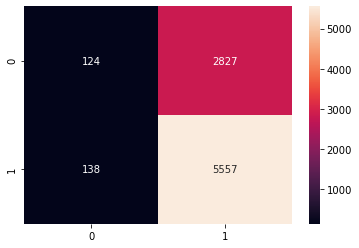

In [152]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.astype(float),y_test_pred)
sns.heatmap(cm,annot=True,fmt='.0f');

In [153]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.52      0.04      0.08      6887
           1       0.66      0.98      0.79     13284

    accuracy                           0.66     20171
   macro avg       0.59      0.51      0.43     20171
weighted avg       0.61      0.66      0.55     20171



In [154]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.47      0.04      0.08      2951
           1       0.66      0.98      0.79      5695

    accuracy                           0.66      8646
   macro avg       0.57      0.51      0.43      8646
weighted avg       0.60      0.66      0.55      8646



In [155]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k = KFold(n_splits = 5, shuffle = True, random_state = 48)
scores = cross_val_score(log_reg,x.astype('float'),y.astype('float'),cv=k,scoring = 'f1_weighted')
print(scores)
log_bias = 1-np.mean(scores)
log_var = np.std(scores)/np.mean(scores)
print('Scores:',scores)
print('Bias error:',1-np.mean(scores))
print('Variance error:', np.std(scores)/np.mean(scores))

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[0.54936877 0.56013687 0.56467194 0.55233162 0.54403608]
Scores: [0.54936877 0.56013687 0.56467194 0.55233162 0.54403608]
Bias error: 0.445890941037391
Variance error: 0.013384089674247283


C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### using params class_weight as balance

In [156]:
log_reg = LogisticRegression(class_weight='balanced')

In [157]:
log_reg_full_model = log_reg.fit(x_train,y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [158]:
y_test_pred = log_reg_full_model.predict(x_test.astype(float))
y_test_pred

array([1, 1, 0, ..., 1, 1, 1])

In [159]:
y_train_pred = log_reg_full_model.predict(x_train.astype(float))
y_train_pred

array([0, 1, 1, ..., 1, 0, 1])

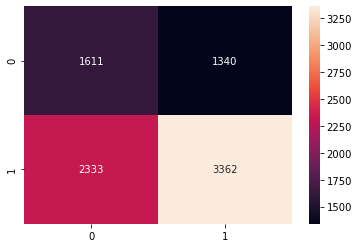

In [160]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.astype(float),y_test_pred)
sns.heatmap(cm,annot=True,fmt='.0f');

In [161]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.41      0.55      0.47      2951
           1       0.72      0.59      0.65      5695

    accuracy                           0.58      8646
   macro avg       0.56      0.57      0.56      8646
weighted avg       0.61      0.58      0.59      8646



In [162]:
from sklearn.metrics import classification_report
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.42      0.55      0.47      6887
           1       0.72      0.60      0.65     13284

    accuracy                           0.58     20171
   macro avg       0.57      0.57      0.56     20171
weighted avg       0.62      0.58      0.59     20171



In [163]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k = KFold(n_splits = 5, shuffle = True, random_state = 48)
scores = cross_val_score(log_reg,x.astype('float'),y.astype('float'),cv=k,scoring = 'f1_weighted')
print(scores)
log_bias = 1-np.mean(scores)
log_var = np.std(scores)/np.mean(scores)
print('Scores:',scores)
print('Bias error:',1-np.mean(scores))
print('Variance error:', np.std(scores)/np.mean(scores))

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[0.58903801 0.57412291 0.59164835 0.5886587  0.58371731]
Scores: [0.58903801 0.57412291 0.59164835 0.5886587  0.58371731]
Bias error: 0.41456294306127073
Variance error: 0.010609471013042328


C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [164]:
prob = log_reg_full_model.predict_proba(x_test)
prob = prob[:,1]

In [165]:
from sklearn.metrics import roc_curve,roc_auc_score

In [166]:
fpr,tpr,thres = roc_curve(y_test,prob)
roc_df = pd.DataFrame({'TPR':tpr,'FPR':fpr,'Threshold':thres})
roc_df

,TPR,FPR,Threshold
0,0.000000,0.000000,1.741792
1,0.000176,0.000000,0.741792
2,0.001580,0.000000,0.727052
3,0.001580,0.000339,0.726875
4,0.002634,0.000339,0.722820
...,...,...,...
3718,0.999122,0.998645,0.266097
3719,0.999298,0.998645,0.263261
3720,0.999298,0.998983,0.262792
3721,1.000000,0.998983,0.246885


Text(0.5, 1.0, 'ROC Curve')

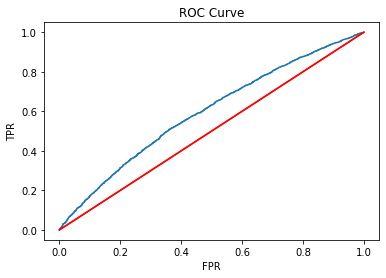

In [167]:
plt.plot(fpr,tpr)
plt.plot([[0,0],[1,1]],color='red')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

### SMOTE

In [168]:
from imblearn.over_sampling import SMOTE

In [169]:
smote = SMOTE(sampling_strategy=1,random_state=10)

In [170]:
x_smote,y_smote = smote.fit_resample(x,y)
x_sm = pd.DataFrame(x_smote, columns=x.columns)
y_sm = pd.DataFrame(y_smote, columns=['TAXI_OUT'])

In [171]:
y_sm.value_counts()

TAXI_OUT
0           18979
1           18979
dtype: int64

In [172]:
x = x_sm
y = y_sm

In [173]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=45)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((26570, 25), (11388, 25), (26570, 1), (11388, 1))

#### LOGISTIC REGRESSION

In [174]:
log_reg = LogisticRegression()

In [175]:
log_reg_full_model = log_reg.fit(x_train,y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [176]:
y_test_pred = log_reg_full_model.predict(x_test.astype(float))
y_test_pred

array([0, 1, 1, ..., 0, 0, 1])

In [177]:
y_train_pred = log_reg_full_model.predict(x_train.astype(float))
y_train_pred

array([0, 0, 0, ..., 1, 1, 0])

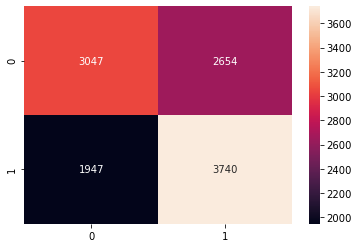

In [178]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.astype(float),y_test_pred)
sns.heatmap(cm,annot=True,fmt='.0f');

In [179]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.61      0.53      0.57      5701
           1       0.58      0.66      0.62      5687

    accuracy                           0.60     11388
   macro avg       0.60      0.60      0.59     11388
weighted avg       0.60      0.60      0.59     11388



In [180]:
from sklearn.metrics import classification_report
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.62      0.55      0.58     13278
           1       0.60      0.67      0.63     13292

    accuracy                           0.61     26570
   macro avg       0.61      0.61      0.61     26570
weighted avg       0.61      0.61      0.61     26570



In [181]:
from sklearn.metrics import accuracy_score
log_accuracy_score_train = accuracy_score(y_train,y_train_pred)
print("Train accuracy = ",log_accuracy_score_train)
log_accuracy_score_test = accuracy_score(y_test,y_test_pred)
print("Test accuracy = ",log_accuracy_score_test)

Train accuracy =  0.6068498306360557
Test accuracy =  0.5959782226905515


In [182]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k = KFold(n_splits = 5, shuffle = True, random_state = 48)
scores_smote = cross_val_score(log_reg,x.astype('float'),y.astype('float'),cv=k,scoring = 'f1_weighted')
print(scores_smote)
log_bias_smote = 1-np.mean(scores_smote)
log_var_smote = np.std(scores)/np.mean(scores_smote)
print('Scores:',scores)
print('Bias error:',1-np.mean(scores_smote))
print('Variance error:', np.std(scores_smote)/np.mean(scores_smote))

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  ret

[0.59916174 0.60090166 0.60093482 0.59877642 0.60855133]
Scores: [0.58903801 0.57412291 0.59164835 0.5886587  0.58371731]
Bias error: 0.39833480603518123
Variance error: 0.005906616459895389


C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or sca

In [183]:
prob = log_reg_full_model.predict_proba(x_test)
prob = prob[:,1]

In [184]:
from sklearn.metrics import roc_curve,roc_auc_score

In [185]:
fpr,tpr,thres = roc_curve(y_test,prob)
roc_df = pd.DataFrame({'TPR':tpr,'FPR':fpr,'Threshold':thres})
roc_df

,TPR,FPR,Threshold
0,0.000000,0.000000,1.838238
1,0.000176,0.000000,0.838238
2,0.001407,0.000000,0.823695
3,0.001407,0.000175,0.819849
4,0.001583,0.000175,0.816655
...,...,...,...
5453,0.999648,0.999123,0.184897
5454,0.999824,0.999123,0.184861
5455,0.999824,0.999825,0.181274
5456,1.000000,0.999825,0.177783


Text(0.5, 1.0, 'ROC Curve')

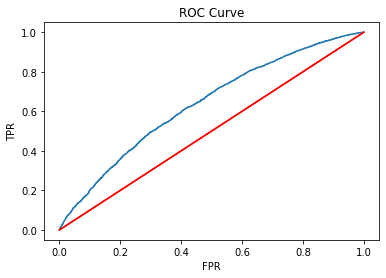

In [186]:
plt.plot(fpr,tpr)
plt.plot([[0,0],[1,1]],color='red')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

#### KNN

In [187]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [188]:
knn_model = knn.fit(x_train,y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [189]:
y_test_pred = knn_model.predict(x_test)
y_train_pred = knn_model.predict(x_train)
y_test_prob_1 = knn_model.predict_proba(x_test)[:,1]

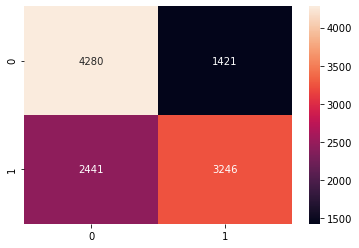

In [190]:
cm = confusion_matrix(y_test,y_test_pred)
sns.heatmap(cm,annot=True,fmt='.0f');

In [191]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81     13278
           1       0.84      0.72      0.78     13292

    accuracy                           0.79     26570
   macro avg       0.80      0.79      0.79     26570
weighted avg       0.80      0.79      0.79     26570



In [192]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.64      0.75      0.69      5701
           1       0.70      0.57      0.63      5687

    accuracy                           0.66     11388
   macro avg       0.67      0.66      0.66     11388
weighted avg       0.67      0.66      0.66     11388



In [193]:
knn_accuracy_score_train = accuracy_score(y_train,y_train_pred)
print("Train accuracy = ",knn_accuracy_score_train)
knn_accuracy_score_test = accuracy_score(y_test,y_test_pred)
print("Test accuracy = ",knn_accuracy_score_test)

Train accuracy =  0.7922845314264207
Test accuracy =  0.6608710923779417


In [194]:
k = KFold(n_splits = 5, shuffle = True, random_state = 48)
scores = cross_val_score(knn,x,y,cv=k,scoring = 'f1_weighted')
knn_bias = 1-np.mean(scores)
knn_var = np.std(scores)/np.mean(scores)
print('Scores:',scores)
print('Bias error:',1-np.mean(scores))
print('Variance error:', np.std(scores)/np.mean(scores))

C:\Users\HP\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

Scores: [0.67022787 0.67999186 0.67106412 0.66636165 0.67893979]
Bias error: 0.32668294300322953
Variance error: 0.00783537589174256


#### ROC CURVE

In [195]:
prob = knn_model.predict_proba(x_test)
prob = prob[:,1]

In [197]:
fpr,tpr,thres = roc_curve(y_test,prob)
roc_df = pd.DataFrame({'TPR':tpr,'FPR':fpr,'Threshold':thres})
roc_df

,TPR,FPR,Threshold
0,0.000000,0.000000,2.0
1,0.120274,0.016839,1.0
2,0.318094,0.083670,0.8
3,0.570775,0.249255,0.6
4,0.799543,0.506578,0.4
5,0.950413,0.796352,0.2
6,1.000000,1.000000,0.0


Text(0.5, 1.0, 'ROC Curve')

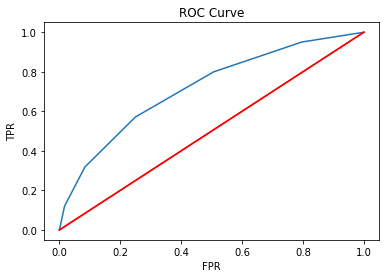

In [198]:
plt.plot(fpr,tpr)
plt.plot([[0,0],[1,1]],color='red')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

#### DECISION TREE

In [199]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=10)

In [200]:
dt_model = dt.fit(x_train,y_train)

In [201]:
y_test_pred = dt_model.predict(x_test)
y_train_pred = dt_model.predict(x_train)
y_test_prob_1 = dt_model.predict_proba(x_test)[:,1]

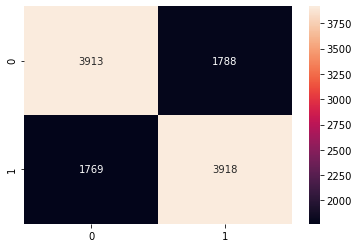

In [202]:
cm = confusion_matrix(y_test,y_test_pred)
sns.heatmap(cm,annot=True,fmt='.0f');

In [203]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13278
           1       1.00      1.00      1.00     13292

    accuracy                           1.00     26570
   macro avg       1.00      1.00      1.00     26570
weighted avg       1.00      1.00      1.00     26570



In [204]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69      5701
           1       0.69      0.69      0.69      5687

    accuracy                           0.69     11388
   macro avg       0.69      0.69      0.69     11388
weighted avg       0.69      0.69      0.69     11388



In [205]:
dt_accuracy_score_train = accuracy_score(y_train,y_train_pred)
print("Train accuracy = ",dt_accuracy_score_train)
dt_accuracy_score_test = accuracy_score(y_test,y_test_pred)
print("Test accuracy = ",dt_accuracy_score_test)

Train accuracy =  0.9996612721114039
Test accuracy =  0.6876536705303828


In [206]:
k = KFold(n_splits = 5, shuffle = True, random_state = 48)
scores = cross_val_score(dt,x,y,cv=k,scoring = 'f1_weighted')
dt_bias = 1-np.mean(scores)
dt_var = np.std(scores)/np.mean(scores)
print('Scores:',scores)
print('Bias error:',1-np.mean(scores))
print('Variance error:', np.std(scores)/np.mean(scores))

Scores: [0.70526111 0.71025873 0.70179295 0.70069857 0.69675167]
Bias error: 0.2970473922795114
Variance error: 0.0064749879187083175


#### ROC CURVE

In [207]:
prob = dt_model.predict_proba(x_test)
prob = prob[:,1]

In [208]:
fpr,tpr,thres = roc_curve(y_test,prob)
roc_df = pd.DataFrame({'TPR':tpr,'FPR':fpr,'Threshold':thres})
roc_df

,TPR,FPR,Threshold
0,0.000000,0.000000,2.0
1,0.688940,0.313629,1.0
2,0.689116,0.313805,0.5
3,1.000000,1.000000,0.0


Text(0.5, 1.0, 'ROC Curve')

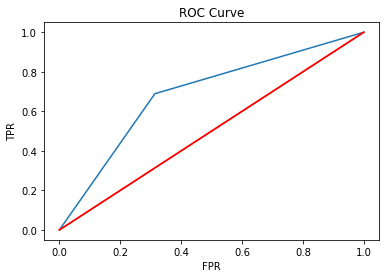

In [209]:
plt.plot(fpr,tpr)
plt.plot([[0,0],[1,1]],color='red')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

#### Random FOREST

In [210]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=10)

In [211]:
rf_model = rf.fit(x_train,y_train)

<ipython-input-211-7df10749aaf0>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model = rf.fit(x_train,y_train)


In [212]:
y_test_pred = rf_model.predict(x_test)
y_train_pred = rf_model.predict(x_train)
y_test_prob_1 = rf_model.predict_proba(x_test)[:,1]

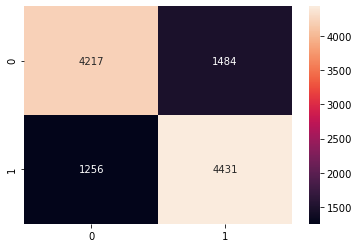

In [213]:
cm = confusion_matrix(y_test,y_test_pred)
sns.heatmap(cm,annot=True,fmt='.0f');

In [214]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13278
           1       1.00      1.00      1.00     13292

    accuracy                           1.00     26570
   macro avg       1.00      1.00      1.00     26570
weighted avg       1.00      1.00      1.00     26570



In [215]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.77      0.74      0.75      5701
           1       0.75      0.78      0.76      5687

    accuracy                           0.76     11388
   macro avg       0.76      0.76      0.76     11388
weighted avg       0.76      0.76      0.76     11388



In [216]:
from sklearn.metrics import accuracy_score
rf_accuracy_score_train = accuracy_score(y_train,y_train_pred)
print("Train accuracy = ",rf_accuracy_score_train)
rf_accuracy_score_test = accuracy_score(y_test,y_test_pred)
print("Test accuracy = ",rf_accuracy_score_test)

Train accuracy =  0.9996612721114039
Test accuracy =  0.7593958552862663


#### ROC CURVE

In [217]:
prob = rf_model.predict_proba(x_test)
prob = prob[:,1]

In [218]:
fpr,tpr,thres = roc_curve(y_test,prob)
roc_df = pd.DataFrame({'TPR':tpr,'FPR':fpr,'Threshold':thres})
roc_df

,TPR,FPR,Threshold
0,0.000000,0.000000,2.000
1,0.001055,0.000175,1.000
2,0.005451,0.000526,0.990
3,0.011254,0.001228,0.980
4,0.016881,0.001579,0.970
...,...,...,...
188,0.999472,0.952640,0.035
189,0.999648,0.969830,0.030
190,0.999824,0.983862,0.020
191,0.999824,0.995264,0.010


Text(0.5, 1.0, 'ROC Curve')

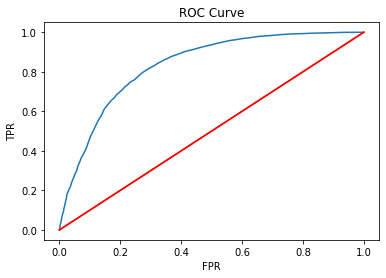

In [219]:
plt.plot(fpr,tpr)
plt.plot([[0,0],[1,1]],color='red')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

#### Hyperparameter tunning since we have overfitting

In [220]:
from sklearn.model_selection import GridSearchCV
params = {'n_estimators':[90, 100, 150, 200],'criterion':['gini','entropy'],
          'max_depth':np.arange(2,10),'min_samples_split':[2, 5, 8]}
rf = GridSearchCV(estimator=rf,param_grid=params,cv=5,scoring='recall')
rf.fit(x_train,y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_split': [2, 5, 8],
                         'n_estimators': [90, 100, 150, 200]},
             scoring='recall')

In [221]:
best = rf.best_params_
best

{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_split': 2,
 'n_estimators': 150}

In [222]:
rf = RandomForestClassifier(**best)

In [223]:
rf_model = rf.fit(x_train,y_train)
y_test_pred = rf_model.predict(x_test)
y_train_pred = rf_model.predict(x_train)

<ipython-input-223-433a5337e605>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model = rf.fit(x_train,y_train)


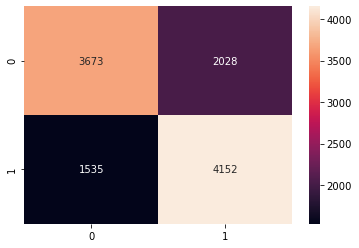

In [224]:
cm = confusion_matrix(y_test,y_test_pred)
sns.heatmap(cm,annot=True,fmt='.0f');

In [225]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.76      0.70      0.73     13278
           1       0.72      0.78      0.75     13292

    accuracy                           0.74     26570
   macro avg       0.74      0.74      0.74     26570
weighted avg       0.74      0.74      0.74     26570



In [226]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.71      0.64      0.67      5701
           1       0.67      0.73      0.70      5687

    accuracy                           0.69     11388
   macro avg       0.69      0.69      0.69     11388
weighted avg       0.69      0.69      0.69     11388



In [227]:
from sklearn.metrics import accuracy_score
rf_accuracy_score_train = accuracy_score(y_train,y_train_pred)
print("Train accuracy = ",rf_accuracy_score_train)
rf_accuracy_score_test = accuracy_score(y_test,y_test_pred)
print("Test accuracy = ",rf_accuracy_score_test)

Train accuracy =  0.7394806172374859
Test accuracy =  0.6871268001404988


In [228]:
k = KFold(n_splits = 5, shuffle = True, random_state = 48)
scores = cross_val_score(rf,x,y,cv=k,scoring = 'f1_weighted')
rf_bias = 1-np.mean(scores)
rf_var = np.std(scores)/np.mean(scores)
print('Scores:',scores)
print('Bias error:',1-np.mean(scores))
print('Variance error:', np.std(scores)/np.mean(scores))

C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed whe

Scores: [0.696115   0.69807938 0.70381624 0.69709938 0.70679562]
Bias error: 0.2996188735861993
Variance error: 0.005963103538557631


#### ROC CURVE

In [229]:
prob = rf_model.predict_proba(x_test)
prob = prob[:,1]

In [230]:
fpr,tpr,thres = roc_curve(y_test,prob)
roc_df = pd.DataFrame({'TPR':tpr,'FPR':fpr,'Threshold':thres})
roc_df

,TPR,FPR,Threshold
0,0.000000,0.000000,1.888516
1,0.000176,0.000000,0.888516
2,0.001231,0.000000,0.841395
3,0.001231,0.000175,0.836680
4,0.003341,0.000175,0.809668
...,...,...,...
4540,1.000000,0.977197,0.187565
4541,1.000000,0.977548,0.187542
4542,1.000000,0.990002,0.167942
4543,1.000000,0.990353,0.167833


Text(0.5, 1.0, 'ROC Curve')

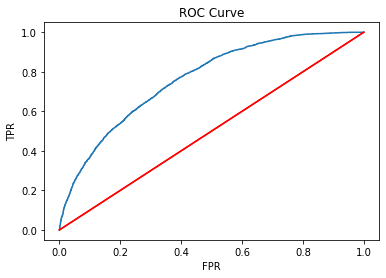

In [231]:
plt.plot(fpr,tpr)
plt.plot([[0,0],[1,1]],color='red')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

#### GRADIENT BOOSTING

In [232]:
from sklearn.ensemble import GradientBoostingClassifier
gd = GradientBoostingClassifier()

In [233]:
gd_model = gd.fit(x_train,y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [234]:
y_test_pred = gd_model.predict(x_test)
y_train_pred = gd_model.predict(x_train)
y_test_prob_1 = gd_model.predict_proba(x_test)[:,1]

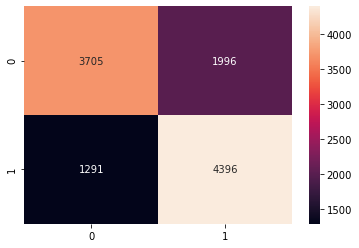

In [235]:
cm = confusion_matrix(y_test,y_test_pred)
sns.heatmap(cm,annot=True,fmt='.0f');

In [236]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.76      0.67      0.71     13278
           1       0.71      0.79      0.75     13292

    accuracy                           0.73     26570
   macro avg       0.73      0.73      0.73     26570
weighted avg       0.73      0.73      0.73     26570



In [237]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.74      0.65      0.69      5701
           1       0.69      0.77      0.73      5687

    accuracy                           0.71     11388
   macro avg       0.71      0.71      0.71     11388
weighted avg       0.71      0.71      0.71     11388



In [238]:
from sklearn.metrics import accuracy_score
gd_accuracy_score_train = accuracy_score(y_train,y_train_pred)
print("Train accuracy = ",gd_accuracy_score_train)
gd_accuracy_score_test = accuracy_score(y_test,y_test_pred)
print("Train accuracy = ",gd_accuracy_score_test)

Train accuracy =  0.7301844185171246
Train accuracy =  0.7113628380751669


In [239]:
k = KFold(n_splits = 5, shuffle = True, random_state = 48)
scores = cross_val_score(gd,x,y,cv=k,scoring = 'f1_weighted')
gd_bias = 1-np.mean(scores)
gd_var = np.std(scores)/np.mean(scores)
print('Scores:',scores)
print('Bias error:',1-np.mean(scores))
print('Variance error:', np.std(scores)/np.mean(scores))

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  re

Scores: [0.7093537  0.71491853 0.71461044 0.70749201 0.72215137]
Bias error: 0.286294792306644
Variance error: 0.007176474390232704


#### ROC CURVE

In [240]:
prob = gd_model.predict_proba(x_test)
prob = prob[:,1]

In [241]:
fpr,tpr,thres = roc_curve(y_test,prob)
roc_df = pd.DataFrame({'TPR':tpr,'FPR':fpr,'Threshold':thres})
roc_df

,TPR,FPR,Threshold
0,0.000000,0.000000,1.877711
1,0.000176,0.000000,0.877711
2,0.001231,0.000000,0.863036
3,0.001231,0.000175,0.859953
4,0.002638,0.000175,0.846500
...,...,...,...
4676,1.000000,0.976320,0.120001
4677,1.000000,0.976671,0.119711
4678,1.000000,0.984038,0.108713
4679,1.000000,0.984389,0.108388


Text(0.5, 1.0, 'ROC Curve')

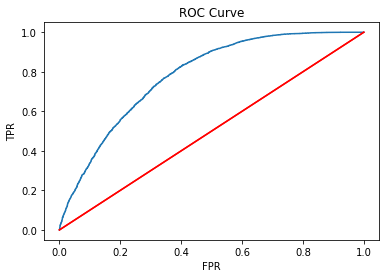

In [242]:
plt.plot(fpr,tpr)
plt.plot([[0,0],[1,1]],color='red')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

#### ADA BOOST MODEL

In [243]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(random_state=10)

In [244]:
ada_model = ada.fit(x_train,y_train)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [245]:
y_test_pred = ada_model.predict(x_test)
y_train_pred = ada_model.predict(x_train)
y_test_prob_1 = ada_model.predict_proba(x_test)[:,1]

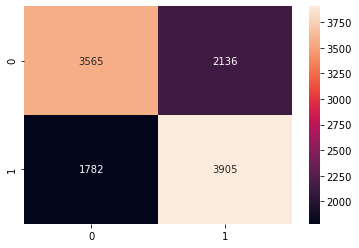

In [246]:
cm = confusion_matrix(y_test,y_test_pred)
sns.heatmap(cm,annot=True,fmt='.0f');

In [247]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.67      0.64      0.65     13278
           1       0.66      0.69      0.67     13292

    accuracy                           0.66     26570
   macro avg       0.66      0.66      0.66     26570
weighted avg       0.66      0.66      0.66     26570



In [248]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.67      0.63      0.65      5701
           1       0.65      0.69      0.67      5687

    accuracy                           0.66     11388
   macro avg       0.66      0.66      0.66     11388
weighted avg       0.66      0.66      0.66     11388



In [249]:
from sklearn.metrics import accuracy_score
ada_accuracy_score_train = accuracy_score(y_train,y_train_pred)
print("Train accuracy = ",ada_accuracy_score_train)
ada_accuracy_score_test = accuracy_score(y_test,y_test_pred)
print("Train accuracy = ",ada_accuracy_score_test)

Train accuracy =  0.6643959352653368
Train accuracy =  0.6559536354056902


In [250]:
k = KFold(n_splits = 5, shuffle = True, random_state = 48)
scores = cross_val_score(ada,x,y,cv=k,scoring = 'f1_weighted')
ada_bias = 1-np.mean(scores)
ada_var = np.std(scores)/np.mean(scores)
print('Scores:',scores)
print('Bias error:',1-np.mean(scores))
print('Variance error:', np.std(scores)/np.mean(scores))

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  re

Scores: [0.65666008 0.66063274 0.66703664 0.66134871 0.66560064]
Bias error: 0.3377442373927668
Variance error: 0.005601787550031544


#### ROC CURVE

In [251]:
prob = ada_model.predict_proba(x_test)
prob = prob[:,1]

In [252]:
fpr,tpr,thres = roc_curve(y_test,prob)
roc_df = pd.DataFrame({'TPR':tpr,'FPR':fpr,'Threshold':thres})
roc_df

,TPR,FPR,Threshold
0,0.000000,0.000000,1.515239
1,0.000176,0.000000,0.515239
2,0.000703,0.000000,0.513149
3,0.001407,0.000000,0.512450
4,0.004044,0.000000,0.510726
...,...,...,...
4798,1.000000,0.995790,0.487021
4799,1.000000,0.996316,0.486967
4800,1.000000,0.997544,0.485814
4801,1.000000,0.997895,0.485709


Text(0.5, 1.0, 'ROC Curve')

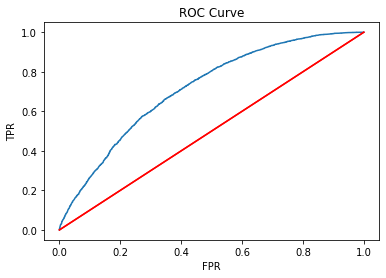

In [253]:
plt.plot(fpr,tpr)
plt.plot([[0,0],[1,1]],color='red')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

#### XG BOOSTING MODEL

In [254]:
from xgboost import XGBClassifier
xg = XGBClassifier(verbosity = 0, random_state = 10)

In [255]:
xg_model = xg.fit(x_train,y_train)

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [256]:
y_test_pred = xg_model.predict(x_test)
y_train_pred = xg_model.predict(x_train)

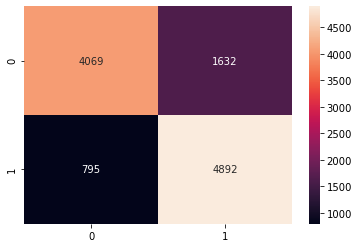

In [257]:
cm = confusion_matrix(y_test,y_test_pred)
sns.heatmap(cm,annot=True,fmt='.0f');

In [258]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.92      0.80      0.86     13278
           1       0.82      0.93      0.87     13292

    accuracy                           0.87     26570
   macro avg       0.87      0.87      0.86     26570
weighted avg       0.87      0.87      0.86     26570



In [259]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77      5701
           1       0.75      0.86      0.80      5687

    accuracy                           0.79     11388
   macro avg       0.79      0.79      0.79     11388
weighted avg       0.79      0.79      0.79     11388



In [260]:
from sklearn.metrics import accuracy_score
xg_accuracy_score_train = accuracy_score(y_train,y_train_pred)
print("Train accuracy = ",xg_accuracy_score_train)
xg_accuracy_score_test = accuracy_score(y_test,y_test_pred)
print("Train accuracy = ",xg_accuracy_score_test)

Train accuracy =  0.8651486639066617
Train accuracy =  0.7868809272918862


In [261]:
k = KFold(n_splits = 5, shuffle = True, random_state = 48)
scores = cross_val_score(xg,x,y,cv=k,scoring = 'f1_weighted')
xg_bias = 1-np.mean(scores)
xg_var = np.std(scores)/np.mean(scores)
print('Scores:',scores)
print('Bias error:',1-np.mean(scores))
print('Variance error:', np.std(scores)/np.mean(scores))

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

Scores: [0.78787692 0.79367866 0.79841388 0.79527677 0.78923712]
Bias error: 0.2071033291167762
Variance error: 0.0048945612467220295


#### ROC CURVE

In [262]:
prob = xg_model.predict_proba(x_test)
prob = prob[:,1]

In [263]:
fpr,tpr,thres = roc_curve(y_test,prob)
roc_df = pd.DataFrame({'TPR':tpr,'FPR':fpr,'Threshold':thres})
roc_df

,TPR,FPR,Threshold
0,0.000000,0.000000,1.995910
1,0.000000,0.000175,0.995910
2,0.000176,0.000175,0.995593
3,0.000176,0.000351,0.991552
4,0.000352,0.000351,0.991333
...,...,...,...
3383,1.000000,0.885283,0.009610
3384,1.000000,0.885634,0.009608
3385,1.000000,0.970531,0.003109
3386,1.000000,0.970882,0.003097


Text(0.5, 1.0, 'ROC Curve')

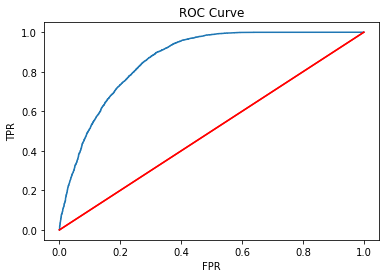

In [264]:
plt.plot(fpr,tpr)
plt.plot([[0,0],[1,1]],color='red')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

# XGboost gridsearchCV

In [265]:
from sklearn.model_selection import GridSearchCV

In [266]:
params ={'n_estimators': [98,99,140,150], 'max_depth':range(3,10,2), 'min_child_weight':range(1,6,2)}
gd_xg = GridSearchCV(estimator=xg,param_grid=params,cv=5,scoring='roc_auc')

In [267]:
gd_xg.fit(x_train,y_train)

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=8,
                                     num_parallel_tree=1, random_state=10,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
        

In [268]:
gd_xg.best_params_

{'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 98}

In [269]:
xg_new=XGBClassifier(max_depth=7, min_child_weight=1, n_estimators=140, random_state=10)

In [270]:
xg_new_model = xg_new.fit(x_train,y_train)

In [271]:
xg_test_pred = xg_new_model.predict(x_test)

In [272]:
print(classification_report(y_test,xg_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.73      0.78      5701
           1       0.76      0.85      0.80      5687

    accuracy                           0.79     11388
   macro avg       0.80      0.79      0.79     11388
weighted avg       0.80      0.79      0.79     11388



<AxesSubplot:>

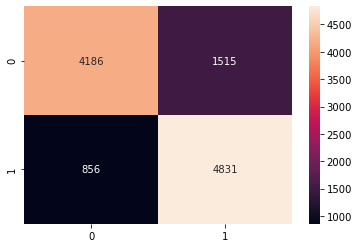

In [273]:
sns.heatmap(confusion_matrix(y_test,xg_test_pred),annot=True,fmt='.0f')

In [274]:
xg_train_new = xg_new_model.predict(x_train)

In [275]:
print(classification_report(y_train,xg_train_new))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92     13278
           1       0.89      0.96      0.92     13292

    accuracy                           0.92     26570
   macro avg       0.92      0.92      0.92     26570
weighted avg       0.92      0.92      0.92     26570



In [276]:
k = KFold(n_splits = 5, shuffle = True, random_state = 48)
scores = cross_val_score(xg_new,x,y,cv=k,scoring = 'f1_weighted')
xg_bias = 1-np.mean(scores)
xg_var = np.std(scores)/np.mean(scores)
print('Scores:',scores)
print('Bias error:',1-np.mean(scores))
print('Variance error:', np.std(scores)/np.mean(scores))

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier objec

Scores: [0.79040482 0.79306887 0.79482983 0.79504737 0.79009079]
Bias error: 0.20731166281054814
Variance error: 0.002661649263289969


In [277]:
xg_new_prob = xg_new_model.predict_proba(x_test)[:,1]

In [278]:
fpr,tpr,thres = roc_curve(y_test,xg_new_prob)
xg_new_roc_df = pd.DataFrame({'TPR':tpr,'FPR':fpr,'Threshold':thres})
xg_new_roc_df

,TPR,FPR,Threshold
0,0.000000,0.000000,1.998544
1,0.000176,0.000000,0.998544
2,0.000352,0.000000,0.998219
3,0.000703,0.000000,0.996728
4,0.001583,0.000000,0.994948
...,...,...,...
3342,1.000000,0.772496,0.006478
3343,1.000000,0.772847,0.006477
3344,1.000000,0.851079,0.003309
3345,1.000000,0.851430,0.003300


Text(0.5, 1.0, 'ROC Curve')

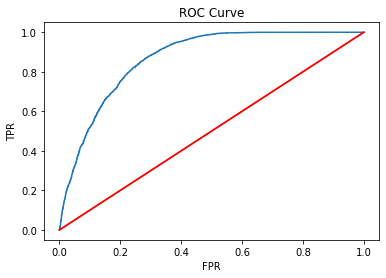

In [279]:
plt.plot(fpr,tpr)
plt.plot([[0,0],[1,1]],color='red')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

In [280]:
xg_accuracy_score_train = accuracy_score(y_train,xg_train_new)
print("Train accuracy = ",xg_accuracy_score_train)
xg_accuracy_score_test = accuracy_score(y_test,xg_test_pred)
print("Test accuracy = ",xg_accuracy_score_test)

Train accuracy =  0.9218667670304855
Test accuracy =  0.7917983842641377


In [281]:
roc_auc_score(y_test,xg_new_prob)

0.8670929032560929

In [282]:
res = pd.DataFrame({'Model':['Log_reg','KNN','DT','RF','GB','ADA','XGB'],
                   'Bias error':[log_bias_smote, knn_bias, dt_bias, rf_bias, gd_bias, ada_bias, xg_bias],
                    'Variance error':[log_var_smote, knn_var, dt_var, rf_var, gd_var, ada_var, xg_var]})
#'accuracy':[log_accuracy_score, knn_accuracy_score, dt_accuracy_score, rf_accuracy_score, gd_accuracy_score, ada_accuracy_score, xg_accuracy_score]

In [283]:
accuracy = pd.DataFrame({'Model':['Log_reg','KNN','DT','RF','GB','ADA','XGB'],
                   'accuracy train':[log_accuracy_score_train, knn_accuracy_score_train, dt_accuracy_score_train, rf_accuracy_score_train, gd_accuracy_score_train, ada_accuracy_score_train, xg_accuracy_score_train],
                    'accuracy test':[log_accuracy_score_test, knn_accuracy_score_test, dt_accuracy_score_test, rf_accuracy_score_test, gd_accuracy_score_test, ada_accuracy_score_test, xg_accuracy_score_test]})
#'accuracy':[log_accuracy_score, knn_accuracy_score, dt_accuracy_score, rf_accuracy_score, gd_accuracy_score, ada_accuracy_score, xg_accuracy_score]

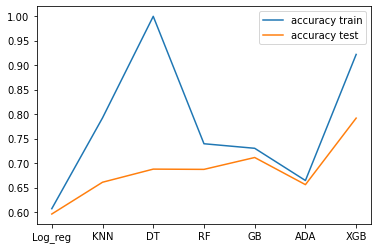

In [284]:
plt.plot(accuracy['Model'], accuracy['accuracy train'])
plt.plot(accuracy['Model'], accuracy['accuracy test'])
plt.legend(['accuracy train','accuracy test'])

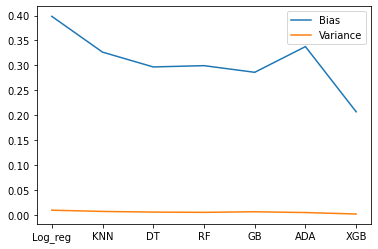

In [285]:
plt.plot(res['Model'], res['Bias error'])
plt.plot(res['Model'], res['Variance error'])
plt.legend(['Bias','Variance'])